# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from bandits import *
from strategies import *

In [2]:
# plot parameters
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         ]
})

In [3]:
########
### READ ME!!!!!!!!!
### If you decide to run a new simulations with different parameters,
### FIRST DELETE ALL THE CONTENT IN THE "scores" FOLDER! Or copy it somewhere else if you need it
####
horizon = 50000
K = 9
means = np.linspace(0.9, 0.89, K)
nplayers = 6
n_simu = 15
cdpe = DPE.CDPE()
strategies = [(MCTopM, 'MCTopM', {'M':nplayers}), (SynchComm, 'SynchComm', {}), (DPE, 'DPE', {})]


# try to load for a warm restart
try:
    scores_1 = np.load('scores/scores_1.npy').item()
except FileNotFoundError:
    scores_1 = {}
    
try:  
    raw_scores_1 = np.load('scores/raw_scores_1.npy').item()
except:
    raw_scores_1 = {}

# Simulate

In [4]:
# if we decide to interrupt the running code, it saves the current state of all the stored scores
try:
    for strat, strat_name, args in strategies:
        #if strat_name not in scores_1.keys():
        try:
            # the number of runs to run for this algo
            nalgo = n_simu-len(raw_scores_1[strat_name])
        except KeyError:
            # case of algo not loaded (ie 0 run already done)
            raw_scores_1[strat_name] = []
            nalgo = n_simu
        for i in tqdm.tqdm(range(nalgo), desc="Simulating {}".format(strat_name)):
            MAB = FullSensingMultiPlayerMAB(means, nplayers=nplayers, strategy=strat, T=horizon, **args) # simulate a run with the chosen parameters
            r, _ = MAB.simulate(horizon)
            raw_scores_1[strat_name].append(r)            
        scores_1[strat_name] = [np.mean(raw_scores_1[strat_name], axis=0),
                                np.std(raw_scores_1[strat_name], axis=0),
                                np.min(raw_scores_1[strat_name], axis=0),
                                np.max(raw_scores_1[strat_name], axis=0)]

        del raw_scores_1[strat_name]
        del r
    
    # also saves the scores if we ran the whole algorithm without interrupting
    np.save('scores/raw_scores_1.npy', raw_scores_1)
    np.save('scores/scores_1.npy', scores_1)
    
except KeyboardInterrupt:
    # save in case of interruption
    print('Number of tries ran for %s : %d' %(strat_name, len(raw_scores_1[strat_name])))
    np.save('scores/raw_scores_1.npy', raw_scores_1)
    np.save('scores/scores_1.npy', scores_1)
    del raw_scores_1

Simulating DPE: 100%|██████████| 15/15 [03:14<00:00, 12.85s/it]


# Plot

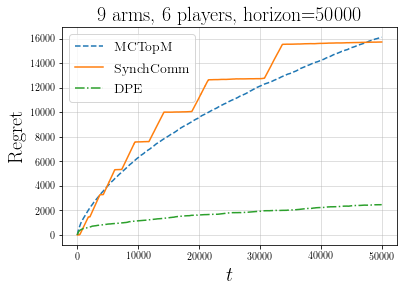

In [5]:
# plot evolution of regret
try:
    scores_1 = np.load('scores/scores_1.npy').item()
except FileNotFoundError:
    scores_1 = {}
    
fig = plt.figure()
horizon_plot = -1
ls = ['--', '-', '-.']
for i,z in enumerate(strategies):
    strat, strat_name, _ = z
    name = strat_name
    plt.plot(scores_1[strat_name][0][:horizon_plot], ls[i], label=name)
plt.title('{} arms, {} players, horizon={}'.format(K, nplayers, horizon), fontsize=20)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('Regret', fontsize=20)
plt.legend(fontsize=14)
plt.grid(alpha=0.5)
fig.savefig('figures/K{}_M{}_delta{}.pgf'.format(K, nplayers, (int)(1000*(means[0]-means[1]))))
plt.show()